# Yet Another Twitter/Python Data Analysis Blogpost
## Geospatially Analyzing Sentiments toward Top U.S. Presidential Candidates
### with Pandas, TextBlob, Seaborn, and Cartopy

Hi, I'm Raj. For my internship this summer, I've been using data science and geospatial Python libraries like xray, numpy, rasterio, cartopy, and more. A week ago, I had a discussion about the most popular U.S. presidential candidate among millenials - and so, I set out to get a rough idea by looking at recent tweets.

I don't explain any of the code in this document, but you can skip the code and just look at the results if you like. If you're interested in going further with this data, I've posted source code and the dataset at  https://github.com/raj-kesavan/arrows.

I'm new to pandas, so if you have any suggestions or comments, please let me know at rajk@berkeley.edu. Enjoy!

I won't be going over how to get the data - it's not very interesting. It's all in `retrieve_tweets.py` in the git repository if you're curious. I searched for 20,000 of the most recent tweets for each of Hillary Clinton, Bernie Sanders, Rand Paul, and Jeb Bush. Because of this, the timeframe for each candidate is different, since Hillary gets a lot more tweets/hour than the other candidates. I've also already done some calculations, specifically of polarity, subjectivity, influence, influenced polarity, and longitude/latitude (all explained later) - this code is in `preprocess.py`.

In [1]:
from preprocess import load_df

Just adding some imports and setting graph display options.

In [2]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import cartopy
pd.set_option('display.max_colwidth', 200)
pd.options.display.mpl_style = 'default'
matplotlib.style.use('ggplot')
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12.0, 8.0]
% matplotlib inline

Let's look at our data!

In [3]:
df = load_df('data/results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 80025
Data columns (total 21 columns):
candidate               80000 non-null object
coordinates             87 non-null object
created_at              80000 non-null datetime64[ns]
favorite_count          80000 non-null object
geo                     87 non-null object
id                      80000 non-null float64
lang                    80000 non-null object
place                   743 non-null object
retweet_count           80000 non-null float64
text                    80000 non-null object
user_followers_count    79994 non-null float64
user_location           53628 non-null object
user_name               79973 non-null object
user_screen_name        79974 non-null object
user_time_zone          50386 non-null object
polarity                80000 non-null float64
subjectivity            80000 non-null float64
influence               79994 non-null float64
influenced_polarity     79994 non-null float64
latitude  

We'll be looking primarily at `candidate`, `created_at`, `lang`, `place`, `user_followers_count`, `user_time_zone`, `polarity`, and `influenced_polarity`.

First I'll look at sentiment values, calculated from the `text` column and TextBlob. Sentiment is composed of two values, polarity - a measure of the positivity or negativity of a text - and subjectivity. Polarity is between -1.0 and 1.0; subjectivity between 0.0 and 1.0.

In [4]:
TextBlob("Tear down this wall!").sentiment

Sentiment(polarity=-0.19444444444444448, subjectivity=0.2888888888888889)

Unfortunately, it doesn't work too well on anything other than English.

In [5]:
TextBlob("Radix malorum est cupiditas.").sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

TextBlob has a cool `translate()` function that uses Google Translate to take care of that for us, but we won't be using it here - just because tweets include a lot of slang and abbreviations that can't be translated very well.

In [6]:
sentence = TextBlob("Radix malorum est cupiditas.").translate()
print(sentence)
print(sentence.sentiment)

The root of evil.
Sentiment(polarity=-1.0, subjectivity=1.0)


All right - let's figure out the most (positively) polarized English tweets.

In [7]:
english_df = df[df.lang == 'en']
english_df.sort('polarity', ascending = False).head(3)[['candidate', 'polarity', 'subjectivity', 'text']]

,candidate,polarity,subjectivity,text
2287,Bernie Sanders,1,1.0,Republicans Welcomed Bernie Sanders to Wisconsin By Calling Him an Extremist. His Response? Perfect. http://t.co/ksaN85UuS8
810,Bernie Sanders,1,0.3,BEST OF SUNDAY TALK CNN SOTU #Sanders draws 2016 record crowd in Iowa-http://t.co/XnSbMweMbW http://t.co/wWqpmsVdEI
31467,Hillary Clinton,1,0.3,@whitehouse but there is one thing i want to be known by all the world: my best wish goes to Lady Hillary Clinton. it's said and done


Extrema don't mean much. We might get more interesting data with mean polarities for each candidate. Let's also look at influenced polarity, which takes into account the number of retweets and followers.

In [8]:
candidate_groupby = english_df.groupby('candidate')
candidate_groupby['polarity', 'influence', 'influenced_polarity'].mean()

,polarity,influence,influenced_polarity
candidate,,,
Bernie Sanders,0.096348,162.142172,14.758500
Hillary Clinton,0.037577,176.315714,7.561452
Jeb Bush,0.026713,318.453703,16.174172
Rand Paul,0.086817,144.550312,10.042045


So tweets about Jeb Bush, on average, aren't as positive as the other candidates, but the people tweeting about Bush get more retweets and followers. 

I used the formula `influence = sqrt(max(followers, 1)) * sqrt(max(retweets, 1))`. You can experiment with different functions if you like - this is in the `influence` function in `preprocess.py`.

We can try to figure out the most influential tweets about Jeb Bush to see what's up.

In [9]:
jeb = candidate_groupby.get_group('Jeb Bush')
jeb_influence = jeb.sort('influence', ascending = False)
jeb_influence[['influence', 'polarity', 'influenced_polarity', 'user_name', 'text', 'created_at']].head(5)

,influence,polarity,influenced_polarity,user_name,text,created_at
52023,89594.614397,0.500000,44797.307199,CNN Breaking News,"Jeb Bush on Donald Trump: ""His views are way out of the mainstream of what most Republicans think."" http://t.co/5K3Gi7AcQG",2015-07-05 02:14:26
55849,68470.590942,0.000000,0.000000,The New York Times,"Jeb Bush, whose wife is Mexican, says he takes Donald Trump’s remarks personally http://t.co/9CZFg4Nbcb",2015-07-04 20:10:06
47246,53754.716258,-0.066667,-3583.647751,Donald J. Trump,Flashback – Jeb Bush says illegal immigrants breaking our laws is an “act of love” http://t.co/p8yFzVuw8w He will never secure the border.,2015-07-05 15:23:20
50459,53641.142046,0.000000,0.000000,CNN,Jeb Bush: Trump comments meant 'to draw attention.'\nhttp://t.co/chKrOnsntE http://t.co/bZnmLgyN7l,2015-07-05 03:55:25
47616,51601.878338,0.200000,10320.375668,Donald J. Trump,Jeb Bush will never secure our border or negotiate great trade deals for American workers. Jeb doesn't see &amp; can't solve the problems.,2015-07-05 15:02:22


Side note: you can see that sentiment analysis isn't perfect - the last tweet is certainly negative toward Jeb Bush, but it was actually assigned a positive polarity. Over a large number of tweets, though, sentiment analysis is more meaningful.

As to the high influence of tweets about Bush: it looks like Donald Trump (someone with a lot of followers) has been tweeting a lot about Bush over the other candidates - one possible reason for Jeb's greater `influenced_polarity`.

In [10]:
df[df.user_name == 'Donald J. Trump'].groupby('candidate').size()

candidate
Jeb Bush    4
dtype: int64

Looks like our favorite toupéed candidate hasn't been tweeting about anyone else!

What else can we do? We know the language each tweet was (tweeted?) in. By the way, each `lang` value is an IANA language tag - you can look them up at https://www.iana.org/assignments/language-subtag-registry/language-subtag-registry.

In [11]:
language_groupby = df.groupby(['candidate', 'lang'])
language_groupby.size()

candidate        lang
Bernie Sanders   ar          1
                 da          2
                 de         55
                 el         33
                 en      19208
                 es         55
                 et          1
                 fr        447
                 in          6
                 it          1
                 ko          1
                 nl         47
                 no          1
                 pl          7
                 pt          8
                 sk          2
                 sl          1
                 sv          7
                 tl          2
                 tr          5
                 und       107
                 vi          3
Hillary Clinton  ar          5
                 de        168
                 en      18100
                 es        841
                 et          2
                 fa          4
                 fr        202
                 hi         31
                         ...  
Jeb Bush         

That's a lot of languages! Let's try plotting to get a better idea, but first, I'll remove smaller language/candidate groups.

In [12]:
largest_languages = language_groupby.filter(lambda group: len(group) > 10)

I'll also remove English, since it would just dwarf all the other languages.

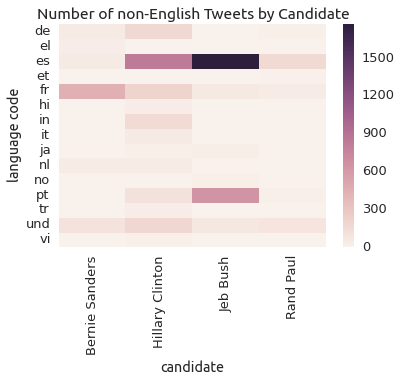

In [13]:
non_english = largest_languages[largest_languages.lang != 'en']
non_english_groupby = non_english.groupby(['lang', 'candidate'], as_index = False)

sizes = non_english_groupby.text.agg(np.size)
sizes = sizes.rename(columns={'text': 'count'})
sizes_pivot = sizes.pivot_table(index='lang', columns='candidate', values='count', fill_value=0)

plot = sns.heatmap(sizes_pivot)
plot.set_title('Number of non-English Tweets by Candidate', family='Ubuntu')
plot.set_ylabel('language code', family='Ubuntu')
plot.set_xlabel('candidate', family='Ubuntu')

Looks like Spanish and Portuguese speakers mostly tweet about Jeb Bush, while Francophones lean more liberal, and Clinton tweeters span the largest range of languages.

We also have the time-of-tweet information.

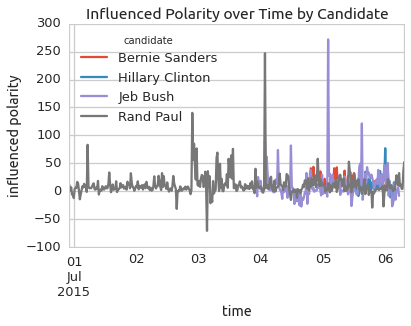

In [14]:
mean_polarities = df.groupby(['candidate', 'created_at']).influenced_polarity.mean()
plot = mean_polarities.unstack('candidate').resample('20min').plot()
plot.set_title('Influenced Polarity over Time by Candidate', family='Ubuntu')
plot.set_ylabel('influenced polarity', family='Ubuntu')
plot.set_xlabel('time', family='Ubuntu')

Since I only took the last 20,000 tweets for each candidate, I didn't receive as large a timespan from Clinton (a candidate with many, many tweeters) as Rand Paul. But we can still analyze the data in terms of hour-of-day.

By the way, the times in the dataframe are in UTC, but I convert to EST below.

In [15]:
top_languages_df = df.groupby('lang').filter(lambda group: len(group) > 75)
top_languages = set(top_languages_df.lang.unique()) - {'und'}
top_languages

{'de', 'en', 'es', 'fr', 'in', 'nl', 'pt'}

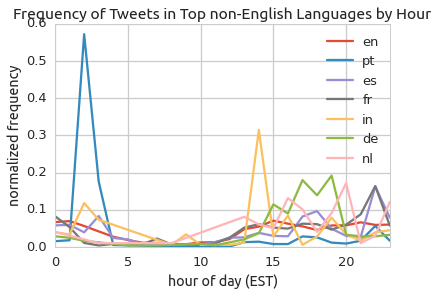

In [16]:
df['hour'] = df.created_at.apply(lambda datetime: datetime.hour) 
for language_code in top_languages:
    lang_df = df[df.lang == language_code]
    normalized = lang_df.groupby('hour').size() / lang_df.lang.count()
    plot = normalized.plot(label = language_code)

plot.set_title('Frequency of Tweets in Top non-English Languages by Hour', family='Ubuntu')
plot.set_ylabel('normalized frequency', family='Ubuntu')
plot.set_xlabel('hour of day (EST)', family='Ubuntu')
plot.legend()

Note that English and French are significantly flatter than the other languages - this means that there's a large spread of speakers all over the globe.

But why is Portuguese spiking at 11pm Brasilia time / 3 am Lisbon time? Let's find out!
My first guess was that maybe there's a single person making a ton of posts at that time.

In [17]:
df_of_interest = df[(df.hour == 3) & (df.lang == 'pt')]

print('Number of tweets:', df_of_interest.text.count())
print('Number of unique users:', df_of_interest.user_name.unique().size)

Number of tweets: 137
Number of unique users: 126


So that's not it. Maybe there was a major event everyone was retweeting?

In [18]:
df_of_interest.text.head(25).unique()

array([ 'Louca de pedra; já não basta o k fizeram ao Iraque e cia ?!\nCompletely INSANE woman; Is not it enough what they... http://t.co/XHUCpfQWNf',
       'RT @4nnak: #OperacaoBetaLab Hillary Clinton diz que Irã continuará a ser ameaça a Israel apesar de acordo nuclear: GLEN, ... http://t.co/28…',
       'RT @2twthebeta: Jeb Bush diz que foi atingido por críticas de Trump a mexicanos. http://t.co/LGsTteBx7Q;',
       'RT @moraesluciano: #BetaLab Jeb Bush diz que foi atingido por críticas de Trump a mexicanos:  http://t.co/65WmTHgKke',
       'RT @jr140797: #betacaralhudosan Jeb Bush diz que foi atingido por críticas de Trump a mexicanos: O pré-can... http://t.co/yQyZTydNnp #betac…',
       'RT @carlosprazere11: Jeb Bush diz que foi atingido por críticas de Trump a mexicanos:  http://t.co/eGmaxgen36',
       'RT @carlosprazere11: Jeb Bush diz que foi atingido por críticas de Trump a mexicanos: O pré-candidato republicano à Casa Branca Jeb... http…',
       'RT @bochacaballero: Com aju

Seems to be a lot of these 'Com ajuda de empresas...' tweets. How many? We can't just count unique ones because they all are different slightly, but we can check for a large-enough substring.

In [19]:
df_of_interest[df_of_interest.text.str.contains('Com ajuda de empresas')].text.count()

125

That's it. To translate,

In [20]:
TextBlob('Com ajuda de empresas, fortuna de Jeb Bush aumentou após gestão na Flórida').translate()

TextBlob("With help from companies, Jeb Bush's fortune rose after management in Florida")

Looks like there was a news article from a Brazilian website (http://www.uol.com.br/) that happened to get a lot of retweets in a short span of time. Still seems a bit odd, but I'm just a programmer - not an investigative journalist.

Since languages can span across different countries, we might get results if we search by location, rather than just language.

We don't have very specific geolocation information other than timezone: let's try plotting candidate sentiment over the 4 major U.S. timezones (Los Angeles, Denver, Chicago, and New York). This is also be a good opportunity to look at a geographical map.

In [21]:
tz_df = english_df.dropna(subset=['user_time_zone'])
us_tz_df = tz_df[tz_df.user_time_zone.str.contains("US & Canada")]
us_tz_candidate_groupby = us_tz_df.groupby(['candidate', 'user_time_zone'])
us_tz_candidate_groupby.influenced_polarity.mean()

candidate        user_time_zone             
Bernie Sanders   Central Time (US & Canada)     18.694226
                 Eastern Time (US & Canada)     20.221507
                 Mountain Time (US & Canada)    13.683829
                 Pacific Time (US & Canada)     16.496358
Hillary Clinton  Central Time (US & Canada)      3.302260
                 Eastern Time (US & Canada)     22.731770
                 Mountain Time (US & Canada)     0.196556
                 Pacific Time (US & Canada)      5.486306
Jeb Bush         Central Time (US & Canada)     14.766734
                 Eastern Time (US & Canada)     28.625515
                 Mountain Time (US & Canada)     6.356858
                 Pacific Time (US & Canada)     16.676979
Rand Paul        Central Time (US & Canada)      6.798783
                 Eastern Time (US & Canada)     15.359912
                 Mountain Time (US & Canada)    10.780279
                 Pacific Time (US & Canada)     12.918267
Name: influenced_polarity, 

That's our raw data: now to plot it on a map. I got the Shapefiles from http://efele.net/maps/tz/world/. First, I read in the Shapefile with Cartopy.

In [22]:
tz_shapes = cartopy.io.shapereader.Reader('world/tz_world_mp.shp')
tz_records = list(tz_shapes.records())
tz_translator = {
     'Eastern Time (US & Canada)': 'America/New_York',
     'Central Time (US & Canada)': 'America/Chicago',
     'Mountain Time (US & Canada)': 'America/Denver',
     'Pacific Time (US & Canada)': 'America/Los_Angeles',
}
american_tz_records = {
    tz_name: next(filter(lambda record: record.attributes['TZID'] == tz_id, tz_records))
    for tz_name, tz_id 
    in tz_translator.items() 
}

Next, I have to choose a projection and plot it (again using Cartopy). I'll also download some featuresets from the Natural Earth dataset to display state borders.

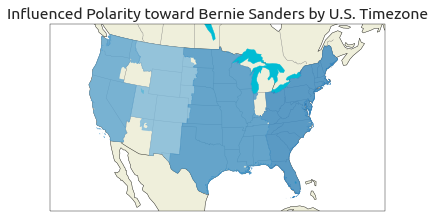

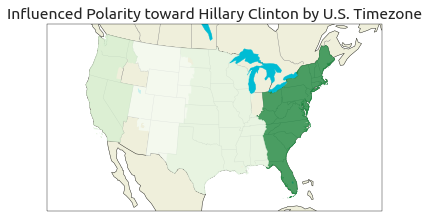

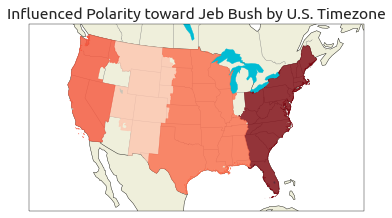

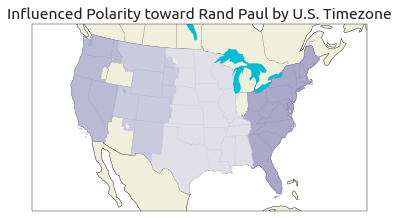

In [23]:
aeacrs = cartopy.crs.AlbersEqualArea(-95, 35)
pccrs = cartopy.crs.PlateCarree()

states_and_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

cmaps = [matplotlib.cm.Blues, matplotlib.cm.Greens, 
         matplotlib.cm.Reds, matplotlib.cm.Purples]
norm = matplotlib.colors.Normalize(vmin=0, vmax=30) 

candidates = df['candidate'].unique()

plt.rcParams['figure.figsize'] = [6.0, 4.0]
for index, candidate in enumerate(candidates):
    plt.figure()
    plot = plt.axes(projection=aeacrs)
    plot.set_extent((-125, -66, 20, 50))
    plot.add_feature(cartopy.feature.LAND)
    plot.add_feature(cartopy.feature.COASTLINE)
    plot.add_feature(cartopy.feature.BORDERS)
    plot.add_feature(states_and_provinces, edgecolor='gray')
    plot.add_feature(cartopy.feature.LAKES, facecolor="#00BCD4")

    for tz_name, record in american_tz_records.items():
        tz_specific_df = us_tz_df[us_tz_df.user_time_zone == tz_name]
        tz_candidate_specific_df = tz_specific_df[tz_specific_df.candidate == candidate]
        mean_polarity = tz_candidate_specific_df.influenced_polarity.mean()

        plot.add_geometries(
            [record.geometry], 
            crs=pccrs,
            color=cmaps[index](norm(mean_polarity)),
            alpha=.8
        )
    plot.set_title('Influenced Polarity toward {} by U.S. Timezone'.format(candidate), family='Ubuntu')
    plt.show()
    print()
plt.rcParams['figure.figsize'] = [12.0, 8.0]

My friend Gabriel Wang pointed out that U.S. timezones other than Pacific don't mean much since each timezone covers both blue and red states, but the data is still interesting. For example, I wasn't expecting Jeb Bush's highest polarity-tweets to come from the East; this is probably Donald Trump (New York, New York) messing with our data again. In a few months I'll look at these statistics with the latest tweets and compare.

What are our friends outside the U.S. saying about our candidates?
Outside of the U.S., if someone is in a major city, the timezone is often that city itself. Here are the top (by number of tweets) non-American 25 timezones in our dataframe.

In [24]:
american_timezones = ('US & Canada|Canada|Arizona|America|Hawaii|Indiana|Alaska'
                      '|New_York|Chicago|Los_Angeles|Detroit|CST|PST|EST|MST')
foreign_tz_df = tz_df[~tz_df.user_time_zone.str.contains(american_timezones)]

foreign_tz_groupby = foreign_tz_df.groupby('user_time_zone')
foreign_tz_groupby.size().sort(inplace = False, ascending = False).head(25)

user_time_zone
Quito                  1719
London                  967
Amsterdam               571
Athens                  368
Bangkok                 249
Beijing                 201
Brasilia                192
New Delhi               182
Tehran                  164
Jakarta                 164
Sydney                  134
Chennai                 133
Paris                   133
West Central Africa     130
Casablanca              129
Baghdad                 119
Dublin                  118
Tijuana                 117
Caracas                 103
Bucharest               100
Berlin                   99
Rome                     96
Madrid                   89
Greenland                86
Belgrade                 79
dtype: int64

I also want to look at polarity, so I'll only use English tweets.

(Sorry, Central/South Americans - my very rough method of filtering out American timezones gets rid of some of your timezones too. Let me know if there's a better way to do this.)

In [25]:
foreign_english_tz_df = foreign_tz_df[foreign_tz_df.lang == 'en']

Now we have a dataframe containing (mostly) world cities as time zones. Let's get the top cities by number of tweets for each candidate, then plot polarities.

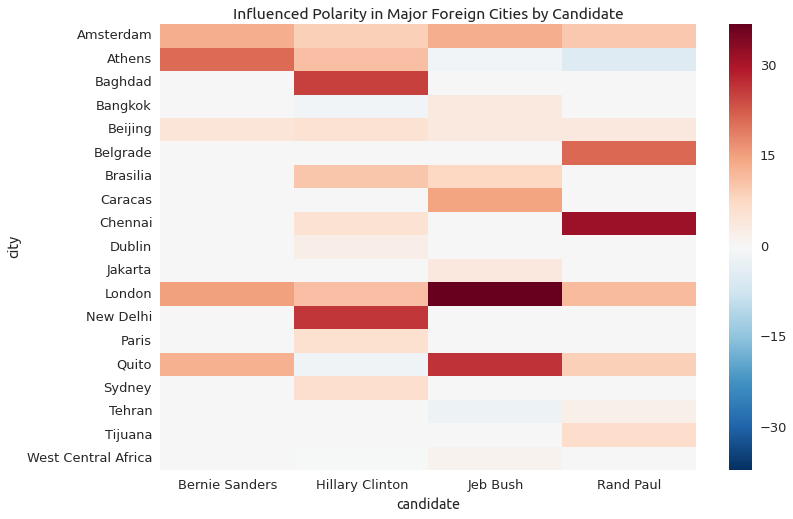

In [26]:
foreign_tz_groupby = foreign_english_tz_df.groupby(['candidate', 'user_time_zone'])
top_foreign_tz_df = foreign_tz_groupby.filter(lambda group: len(group) > 40)

top_foreign_tz_groupby = top_foreign_tz_df.groupby(['user_time_zone', 'candidate'], as_index = False)

mean_influenced_polarities = top_foreign_tz_groupby.influenced_polarity.mean()

pivot = mean_influenced_polarities.pivot_table(
    index='user_time_zone', 
    columns='candidate', 
    values='influenced_polarity', 
    fill_value=0)

plot = sns.heatmap(pivot)
plot.set_title('Influenced Polarity in Major Foreign Cities by Candidate', family='Ubuntu')
plot.set_ylabel('city', family='Ubuntu')
plot.set_xlabel('candidate', family='Ubuntu')

Exercise for the reader: why is Rand Paul disliked in Athens? (you can probably guess)

Greco-libertarian relations aside, the data shows that London and Amsterdam are among the most influential of cities, with the former leaning toward Jeb Bush and the latter about neutral.

In India, Clinton-supporters reside in New Delhi while Chennai (or Madras) tweeters like Rand Paul. In 2014, New Delhi constituents voted for the conservative Bharatiya Janata Party while Chennai voted for the more liberal All India Anna Dravida Munnetra Kazhagam Party - so there seems to be some kind of cultural difference between the voters of 2014 and the tweeters of today.

Last thing I thought was interesting: Athens has the highest mean polarity for Bernie Sanders, the only city for which this is the case. Could this have anything to do with the recent economic crisis, 'no' vote for austerity, and Bernie's social democratic tendencies?

Finally, I'll look at what little specific geolocation data we have. First I'll plot everything on a world map, then break it up by candidate in the U.S.

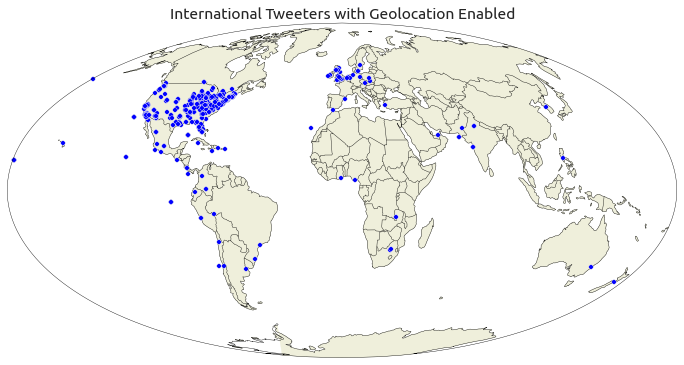

In [27]:
df_place = df.dropna(subset=['place'])
mwcrs = cartopy.crs.Mollweide()

plot = plt.axes(projection=mwcrs)
plot.set_global()
plot.add_feature(cartopy.feature.LAND)
plot.add_feature(cartopy.feature.COASTLINE)
plot.add_feature(cartopy.feature.BORDERS)

plot.scatter(
    list(df_place.longitude), 
    list(df_place.latitude), 
    transform=pccrs, 
    zorder = 2
)
plot.set_title('International Tweeters with Geolocation Enabled', family='Ubuntu')

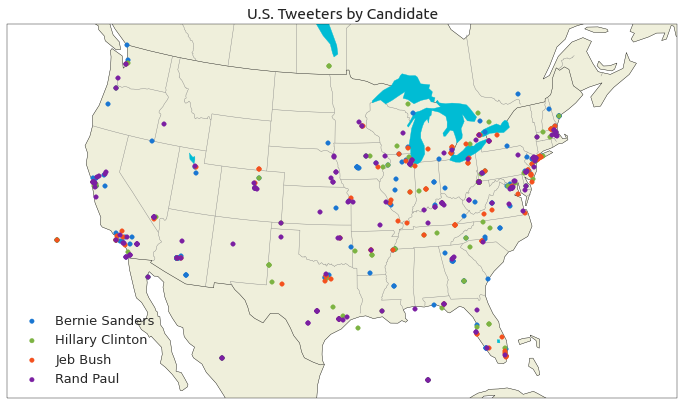

In [28]:
plot = plt.axes(projection=aeacrs)

plot.set_extent((-125, -66, 20, 50))

plot.add_feature(cartopy.feature.LAND)
plot.add_feature(cartopy.feature.COASTLINE)
plot.add_feature(cartopy.feature.BORDERS)
plot.add_feature(states_and_provinces, edgecolor='gray')
plot.add_feature(cartopy.feature.LAKES, facecolor="#00BCD4")

candidate_groupby = df_place[df_place.candidate!='eb Bush'].groupby('candidate', as_index = False)

colors = ['#1976d2', '#7cb342', '#f4511e', '#7b1fa2']
for index, (name, group) in enumerate(candidate_groupby):
    longitudes = group.longitude.values
    latitudes = group.latitude.values
    plot.scatter(longitudes, latitudes, transform=pccrs, 
               color=colors[index], label=name,
               zorder=5)
plot.set_title('U.S. Tweeters by Candidate', family='Ubuntu')
plt.legend(loc='lower left')
plt.show()

There aren't enough points to do sentiment analysis on, but it's a nice (and predictable) scatterplot of U.S. tweeters - centered around L.A., the Bay Area, Chicago, New York, and Boston.

That's all I have for now. 

If you found this interesting and are curious for more, I encourage you to download the dataset (or get your own dataset based on your interests) and share your findings.

Source code is at https://github.com/raj-kesavan/arrows, and I can be reached at raj.ksvn@gmail.com for any questions, comments, or criticism. Looking forward to hearing your feedback!